In [2]:
from PIL import Image
import os

# Carpetas de entrada y salida
input_folder = "/content/gatos"
output_folder = "/content/cats_resized"

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Redimensionar las imágenes
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
        img_path = os.path.join(input_folder, filename)
        img = Image.open(img_path)
        # Reemplazar Image.ANTIALIAS con Image.Resampling.LANCZOS
        img_resized = img.resize((128, 128), Image.Resampling.LANCZOS)  # Redimensionar a 128x128
        img_resized.save(os.path.join(output_folder, filename))  # Guardar en la carpeta de salida
        print(f"{filename} redimensionada y guardada en {output_folder}")

print("Todas las imágenes se han redimensionado correctamente.")

cat.1148.jpg redimensionada y guardada en /content/cats_resized
cat.8691.jpg redimensionada y guardada en /content/cats_resized
Todas las imágenes se han redimensionado correctamente.


In [5]:
!pip install diffusers transformers accelerate scipy safetensors

In [6]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2s8dg_yk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2s8dg_yk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [7]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 463 (delta 175), reused 135 (delta 135), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 38.54 MiB/s, done.
Resolving deltas: 100% (241/241), done.


In [8]:

import os, sys
from os import path
sys.path.append(path.join(os.getcwd(), "GroundingDINO")) # Only the path should be appended

In [9]:
import os
os.chdir('/content/GroundingDINO')

In [10]:
!pip install -e .

Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
  Attempting uninstall: groundingdino
    Found existing installation: groundingdino 0.1.0
    Uninstalling groundingdino-0.1.0:
      Successfully uninstalled groundingdino-0.1.0
  Running setup.py develop for groundingdino


In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [12]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

In [13]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [14]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [15]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [16]:
import os
#from groundingdino.util.inference import load_image, predict
#from groundingdino.util.utils import annotate

# Configuraciones
TEXT_PROMPT = "cat"  # Texto para identificar el objeto
BOX_THRESHOLD = 0.3   # Umbral de puntuación de las cajas
TEXT_THRESHOLD = 0.25 # Umbral de puntuación del texto

input_images_folder = "/content/cats_resized"  # Carpeta de imágenes
output_labels_folder = "/content/cat_yolo_labels"  # Carpeta de etiquetas YOLO
os.makedirs(output_labels_folder, exist_ok=True)

# Función para convertir cajas a formato YOLO
def generate_yolo_format(boxes, image_width, image_height):
    yolo_labels = []
    for box in boxes:
        x1, y1, x2, y2 = box.tolist()
        x_center = ((x1 + x2) / 2) / image_width
        y_center = ((y1 + y2) / 2) / image_height
        box_width = (x2 - x1) / image_width
        box_height = (y2 - y1) / image_height
        class_id = 0  # Clase fija
        yolo_labels.append([class_id, x_center, y_center, box_width, box_height])
    return yolo_labels

# Función para guardar etiquetas en formato YOLO
def save_yolo_labels(labels, output_path):
    with open(output_path, 'w') as f:
        for label in labels:
            f.write(f"{label[0]} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

# Procesar imágenes y generar etiquetas YOLO
for image_name in os.listdir(input_images_folder):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_images_folder, image_name)

        # Cargar imagen
        image_source, image = load_image(image_path)

        # Predecir cajas, puntuaciones y frases
        boxes, logits, phrases = predict(
            model=groundingdino_model,  # Tu modelo cargado
            image=image,
            caption=TEXT_PROMPT,
            box_threshold=BOX_THRESHOLD,
            text_threshold=TEXT_THRESHOLD
        )

        # Anotar imagen con las cajas detectadas (opcional)
        annotated_frame = annotate(
            image_source=image_source,
            boxes=boxes,
            logits=logits,
            phrases=phrases
        )
        # Convertir BGR a RGB si deseas mostrar o guardar la imagen anotada
        annotated_frame = annotated_frame[..., ::-1]

        # Generar etiquetas YOLO
        image_height, image_width = image_source.shape[:2]
        yolo_labels = generate_yolo_format(boxes, image_width, image_height)

        # Guardar etiquetas YOLO
        output_label_path = os.path.join(output_labels_folder, f"{os.path.splitext(image_name)[0]}.txt")
        save_yolo_labels(yolo_labels, output_label_path)

        print(f"Etiquetas YOLO para {image_name} guardadas en {output_label_path}")

print("¡Proceso completado! Etiquetas YOLO generadas.")

# Opcional: Descargar etiquetas como archivo ZIP
#from google.colab import files
#import shutil

#shutil.make_archive("rock_yolo_labels", 'zip', output_labels_folder)
#files.download("rock_yolo_labels.zip")
#print("Descarga tus etiquetas YOLO generadas.")

#Cargar SAM model


Etiquetas YOLO para cat.1148.jpg guardadas en /content/cat_yolo_labels/cat.1148.txt
Etiquetas YOLO para cat.8691.jpg guardadas en /content/cat_yolo_labels/cat.8691.txt
¡Proceso completado! Etiquetas YOLO generadas.


In [17]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-11-21 03:57:13--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.108, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  39.3MB/s    in 34s     

2024-11-21 03:57:47 (72.7 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



In [18]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint))

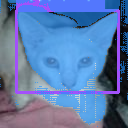

In [23]:
# set image
image_source, image = load_image('/content/cats_resized/cat.8691.jpg')
sam_predictor.set_image(image_source)
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2])
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = None,
            multimask_output = False,
        )
def show_mask(mask, image):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

In [ ]:
import os
from PIL import Image
import numpy as np

# Definir el directorio de entrada y salida
input_dir = '/content/cats_resized'
output_dir = '/content/cats_segmentation'

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Función para mostrar la máscara y aplicar sobre la imagen
def show_mask(mask, image):
    color = np.array([30/255, 144/255, 255/255, 0.6])  # Color azul con transparencia
    h, w = mask.shape[-2:]  # Dimensiones de la máscara
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)  # Aplicar el color a la máscara

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")  # Convertir la imagen original a RGBA
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")  # Convertir la máscara a RGBA

    # Combinar la imagen original con la máscara aplicada
    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

# Iterar sobre todas las imágenes en la carpeta 'cats_resized'
for image_name in os.listdir(input_dir):
    if image_name.endswith(('.jpg', '.jpeg', '.png')):  # Filtrar solo imágenes con estas extensiones
        # Cargar la imagen
        image_path = os.path.join(input_dir, image_name)
        image_source, image = load_image(image_path)  # Suponiendo que 'load_image' carga la imagen correctamente
        sam_predictor.set_image(image_source)

        # Predicción sin utilizar la caja
        masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=None,  # Aquí no se pasa la caja
            multimask_output=False,
        )

        # Aplicar la máscara sobre la imagen
        annotated_frame_with_mask = show_mask(masks[0][0], image)

        # Guardar la imagen resultante en la carpeta de salida
        output_image_path = os.path.join(output_dir, f"seg_{image_name}")
        Image.fromarray(annotated_frame_with_mask).save(output_image_path)
        print(f"Imagen guardada en {output_image_path}")


In [22]:
# set image
image_source, image = load_image('/content/cats_resized/cat.8691.jpg')
sam_predictor.set_image(image_source)

# Elimina la parte de las cajas si no es necesaria
# H, W, _ = image_source.shape
# boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
# transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2])

# Predicción sin utilizar la caja (usando solo la máscara)
masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=None,  # Aquí no se pasa la caja
            multimask_output=False,
        )

# Función para mostrar la máscara sobre la imagen
def show_mask(mask, image):
    color = np.array([30/255, 144/255, 255/255, 0.6])  # Color azul con transparencia
    h, w = mask.shape[-2:]  # Dimensiones de la máscara
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)  # Aplicar el color a la máscara

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")  # Convertir la imagen original a RGBA
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")  # Convertir la máscara a RGBA

    # Combinar la imagen original con la máscara aplicada
    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

# Mostrar la máscara en la imagen anotada
annotated_frame_with_mask = show_mask(masks[0][0], image)  # Cambié annotated_frame por image para usar la imagen original
Image.fromarray(annotated_frame_with_mask)


AttributeError: 'Tensor' object has no attribute '__array_interface__'